In [4]:
# imports
%matplotlib notebook  
import numpy as np
import pandas as pd
from simanneal import Annealer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from deap import algorithms, base, creator, tools
import random
import warnings
warnings.filterwarnings('ignore')

# *Self Assessment: Simulated Annealing for Gerrymandering*

In [4]:
import numpy as np
import pandas as pd

# set the data and define the objective function
num_districts = 10
num_cities = 18

dems = [152,81,75,34,62,38,48,74,98,66,83,86,72,28,112,45,93,72]
reps = [62,59,83,52,87,87,69,49,62,72,75,82,83,53,98,82,68,98]
cities = pd.DataFrame( data = {'dems':dems, 'reps':reps})

# almost the same as in Lesson 4, but we return -fitness so that our minimization annealing can find max
def fitness_districts(assign, cities):
    df = cities.groupby(assign).sum()
    fitness = sum( df['reps'] > df['dems'] )
    total_voters = np.zeros(num_districts,dtype=np.int32)
    total_voters[df.index] = df.sum(axis=1)
    fitness-= np.abs(np.minimum(np.maximum(total_voters,150),350)-total_voters).sum()
    return -fitness # we return a tuple with the fitness ###

def move_one_city(assign, num_districts):
    num_cities = assign.shape[0] # or len(assign)
    new_assign = assign.copy()
    switch_city = np.random.randint(num_cities) # which city to assign new random district
    while new_assign[switch_city] == assign[switch_city]: # loops until new and old are different
        new_assign[ switch_city] = np.random.randint(num_districts)
    return new_assign

# for printing out an assignment of cities to districts
def summarize_districts(assign, cities, num_districts):
    reps = np.zeros(num_districts, dtype=np.int32)
    dems = np.zeros(num_districts, dtype=np.int32)
    df = cities.groupby(assign).sum()
    reps[df.index] = df['reps']
    dems[df.index] = df['dems']
    total = reps + dems
    delta = np.minimum(np.maximum(total, 150), 350) - total
    rep_win = reps > dems
    dict = {
        'reps': reps,
        'dems': dems,
        'total': total,
        'rep_win': rep_win
    }
    return (pd.DataFrame(data=dict))

In [41]:
# main loop for annealing

# note we change dist_mat to two arguments: cities and num_districts
# only lines with ### had changes from simanneal_tsp
def simanneal_gerry(init_state, cities, num_districts, max_no_improve, init_temp, alpha): ###

    curr_state = init_state
    curr_obj = fitness_districts(curr_state, cities) ###
    best_state = curr_state
    best_obj = curr_obj

    # stop search if no better state is found within max_no_improve iterations
    num_moves_no_improve = 0
    iterations = 0
    temp = init_temp

    # save history for plotting after optimization
    history = np.array([[iterations, curr_obj, best_obj]])

    while (num_moves_no_improve < max_no_improve):
        num_moves_no_improve += 1
        iterations += 1  # just for tracking
        new_state = move_one_city(curr_state, num_districts) ###
        new_obj = fitness_districts(new_state, cities) ###
        delta = curr_obj - new_obj
        prob = np.exp(min(delta, 0) / temp) ### # compute prob accept uphill move

        if new_obj < curr_obj or np.random.uniform() < prob : ### # accept if decrease or rand < prob
            curr_state = new_state
            curr_obj = new_obj
            if curr_obj < best_obj: # keep track of best ever
                best_state = curr_state
                best_obj = curr_obj
                num_moves_no_improve = 0
                
        temp *= alpha

        history = np.vstack( (history, np.array([[iterations,curr_obj,best_obj]]) ) )

    return best_state, best_obj, iterations, history

# apply simanneal_gerry() to the gerrymandering problem
# you might have to experiment with the parameters here
max_no_improve = 2000
init_temp = 1000
alpha = 0.997

# uncomment the next line to see a solution where republicans win 9 districts
# must have 2000, 1000, 0.997 as the parameters above
# np.random.seed(16)

init_assign = np.random.randint(low=0,high=num_districts,size = num_cities)

best_assign, best_fitness, iterations, history = simanneal_gerry(init_assign, cities, num_districts, max_no_improve, init_temp, alpha)

print(f"Republicans won {-best_fitness} districts.")
summarize_districts(best_assign, cities, num_districts)

Republicans won 8 districts.


,reps,dems,total,rep_win
0,150,146,296,True
1,157,153,310,True
2,141,114,255,True
3,144,143,287,True
4,136,112,248,True
5,121,121,242,False
6,162,145,307,True
7,165,158,323,True
8,62,152,214,False
9,83,75,158,True


This seems to find good solutions with Republicans winning 7 or 8 districts (it does rarely find 9).  However, the optimum is 9 districts, we'll see if the simanneal package does better.  While not required we plot the search performance in the cell below:

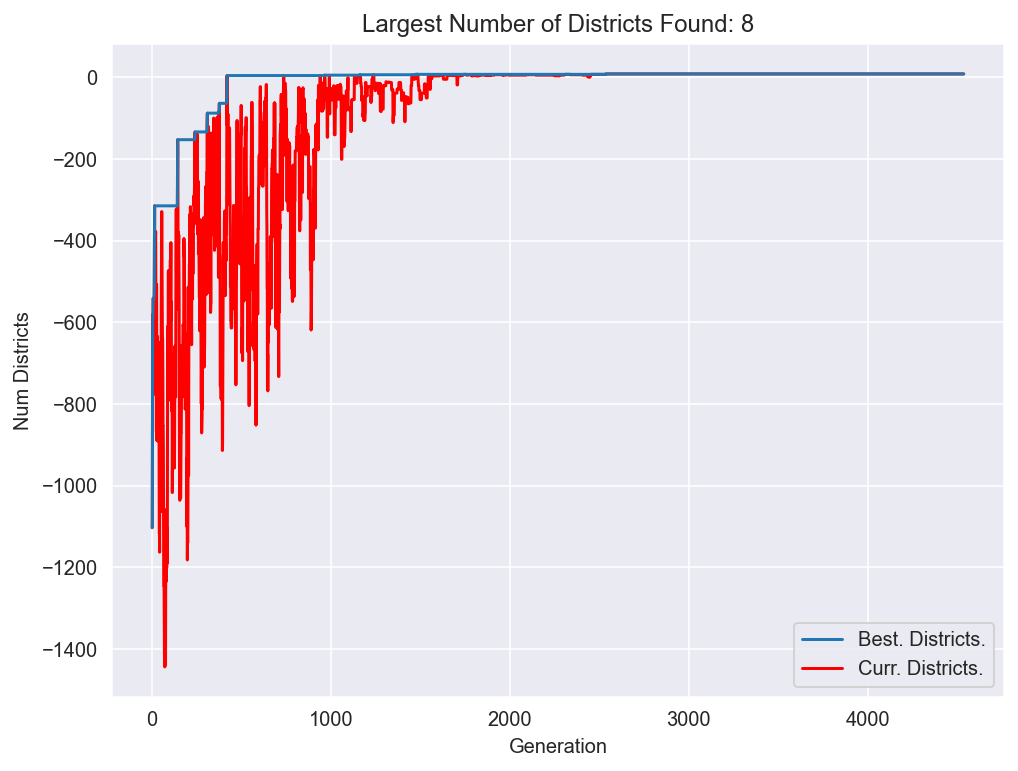

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure(figsize=(8, 6))
line_min, = plt.plot(history[:,0], -history[:,1], label='Curr. Districts.',color='red')
line_curr, = plt.plot(history[:,0],-history[:,2], label='Best. Districts.')
plt.xlabel('Generation')
plt.ylabel('Num Districts')
plt.legend(handles=[line_curr, line_min])
plt.title('Largest Number of Districts Found: {:d}'.format(int(-best_fitness)));

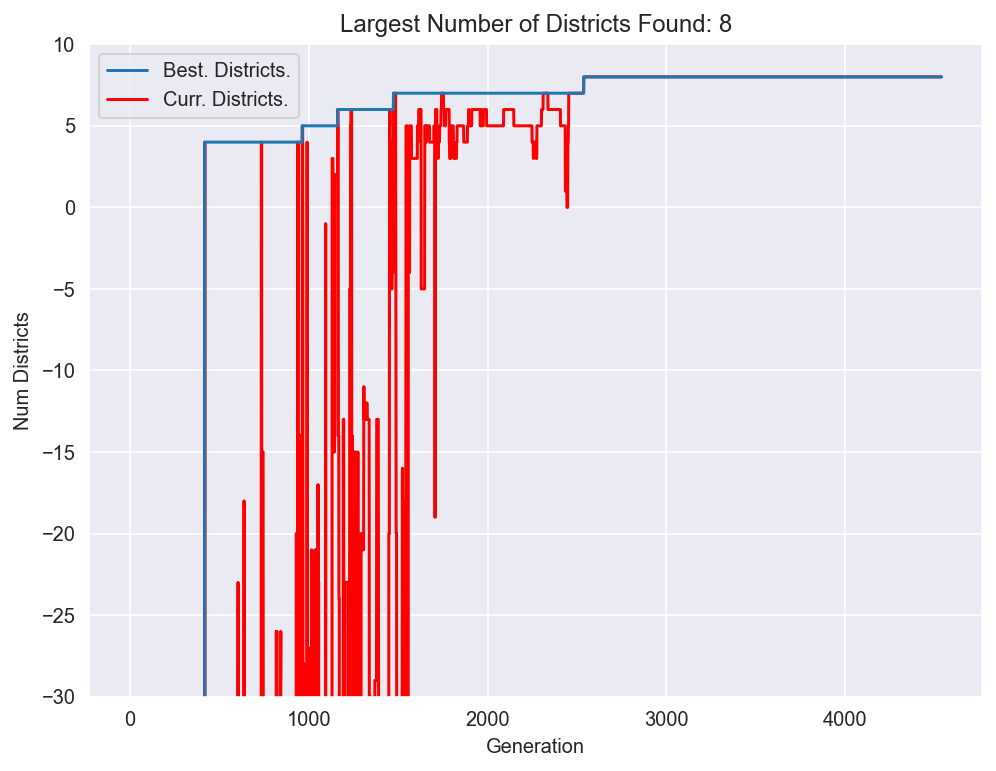

In [43]:
# here is the same graph, but we change the y-axis to -30 to 10 so we can see how the number of districts improves
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure(figsize=(8, 6))
line_min, = plt.plot(history[:,0], -history[:,1], label='Curr. Districts.',color='red')
line_curr, = plt.plot(history[:,0],-history[:,2], label='Best. Districts.')
plt.ylim(-30,10)
plt.xlabel('Generation')
plt.ylabel('Num Districts')
plt.legend(handles=[line_curr, line_min])
plt.title('Largest Number of Districts Found: {:d}'.format(int(-best_fitness)));

# <font color = "blue"> Self Assessment: Simulated Annealing for Gerrymandering - part 2</font>

In [6]:
# relies on the cities dataframe defined above

from simanneal import Annealer

class GerrymanderingProblem(Annealer):

    # pass extra data (the distance matrix) into the constructor
    def __init__(self, state, cities_df, num_districts):
        self.cities = cities_df
        self.num_dist = num_districts
        super(GerrymanderingProblem, self).__init__(state)  # important!

    def move(self):
        """Move one city to another district.  Doesn't check to make sure city actually changes"""
        assign = self.state
        num_cities = len(assign)
        num_districts = self.num_dist
        assign[ np.random.randint(num_cities)] = np.random.randint(self.num_dist)
    
    def energy(self):
        """Compute number of districts - penalty for too small or too large.  Note that 
        we've negated the return value so that we can minimize to find a maximum"""
        cities = self.cities
        assign = self.state
        #print(assign)
        df = cities.groupby(assign).sum()
        fitness = sum( df['reps'] > df['dems'] )
        total_voters = np.zeros(num_districts,dtype=np.int32)
        total_voters[df.index] = df.sum(axis=1)
        fitness-= np.abs(np.minimum(np.maximum(total_voters,150),350)-total_voters).sum()
        return -fitness

initial_assign = np.random.randint(low=0,high=num_districts,size = num_cities)
gerrymander = GerrymanderingProblem(initial_assign, cities, num_districts)
#gerrymander.set_schedule(gerrymander.auto(minutes=.2)) #set approximate time to find results
gerrymander.Tmax = 25000.0  # Max (starting) temperature
gerrymander.Tmin = 2.5      # Min (ending) temperature
gerrymander.steps = 5000   # Number of iterations
gerrymander.updates = 100   # Number of updates (by default an update prints to stdout)
gerrymander.copy_strategy = "method"
best_assign, best_fitness = gerrymander.anneal()

summarize_districts(best_assign, cities)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -2.00    20.00%     2.00%     0:00:08     0:00:00

,reps,dems,total,rep_win
0,108,155,263,False
1,144,143,287,True
2,166,165,331,True
3,83,75,158,True
4,154,152,306,True
5,162,145,307,True
6,83,72,155,True
7,62,152,214,False
8,192,100,292,True
9,167,160,327,True


Whether using the auto temperate schedule or a manually selected temperature, this usually returns a result of 7 or 8 districts.  Still not optimal.  This search space is huge and a trajectory based method has a tough time exploring the vast space!

# <font color = "blue"> Self Assessment: Continuous Self Annealing </font> 

In [7]:
# the argument to the objective function is a list that contains the values of x and y
def f(xy):
    obj = 0.2 + sum(xy**2 - 0.1*np.cos(6*np.pi*xy))
    return obj

current_x = np.random.uniform(low=-1, high=1, size=2)
current_obj = f(current_x)
best_x = current_x
best_obj = current_obj
temp = 5  # choose initial temperature around the beginning tour distance
alpha = 0.95
iteration = 1
max_iterations = 200
# save some results for plotting
trajectory = [[iteration, current_x[0], current_x[1], current_obj, best_obj]]

while (iteration < max_iterations):  # could have also used a for loop
    new_x = current_x + np.random.normal(loc=0, scale=0.1, size=2)
    new_x = np.minimum([1, 1], np.maximum([-1, -1], new_x))
    new_obj = f(new_x)
    delta = current_obj - new_obj
    prob = min(np.exp(np.min(delta, 0) / temp), 1)
    accept = new_obj < current_obj or np.random.uniform() < prob
    if accept:
        current_x = new_x
        current_obj = new_obj
        if current_obj < best_obj:
            best_x = current_x
            best_obj = current_obj
        trajectory.append(
            [iteration, current_x[0], current_x[1], current_obj, best_obj])
    temp *= alpha
    iteration += 1

trajectory = np.array(trajectory)
fig = plt.figure(figsize=(5, 3.5))
line_best, = plt.plot(trajectory[:,0],trajectory[:,4],label='Best Val')
line_curr, = plt.plot(trajectory[:,0],trajectory[:,3],label='Curr Val',color='red')
plt.xlabel('Iteration')
plt.ylabel('Function Value')
plt.legend(handles=[line_best, line_curr])
plt.title('Smallest Val. Found: {:0.4f}'.format(best_obj));
    
print("The smallest value found was {:0.4f} at x = {:0.4f} and y = {:0.4f}".format(best_obj, best_x[0], best_x[1]))

<IPython.core.display.Javascript object>

There is no exact answer here.  Starting at a higher temperature, T = 5, and decreasing the temperature more slowly, alpha = .95 both seem to improve convergence.  This allows more bad moves.  Also decrease the scale of the moves in the normal distribution seems to help.

# <font color = "blue"> Self Assessment: Continuous Self Annealing with `simanneal` </font> 

In [8]:
# continuous optimization with simanneal
from simanneal import Annealer

class NonConvex2D(Annealer):

    # no extra data so just initialize with state
    def __init__(self, state):
        super(NonConvex2D, self).__init__(state)  # important!

    def move(self):
        """Add a perturbation selected from normal distribution"""
        xy = self.state
        # scale = sd is selected so that 6 standard deviations fit inside bounds
        xy_new = xy + np.random.normal(loc = 0,scale =.1,size=2)
        # clip to fit bounds
        xy_clipped = np.minimum([1,1],np.maximum([-1,-1],xy_new))
        self.state = xy_clipped
    
    def energy(self):
        x = self.state
        return 0.2 + sum( x**2 - 0.1*np.cos(6*np.pi*x))

x0 = np.random.uniform(low=-1,high=1,size=2)
problem2D = NonConvex2D( x0 )
problem2D.set_schedule(problem2D.auto(minutes=.5))
problem2D.copy_strategy = "method" # we're using np.array to hold our state variable, so we'll use .copy() to clone
best_x, best_fun = problem2D.anneal()

(best_fun,best_x)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00002          0.00     0.00%     0.00%     0:00:02    -1:59:59 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00002          0.00     0.01%     0.01%     0:00:25     0:00:00

(1.1563966029193296e-07, array([5.51683976e-05, 5.58468658e-05]))

Again, there isn't an exact answer.  Increasing the time for the auto schedule and decreasing the scale of the moves seems to help the search get closer to the exact optimum value.  Moving randomly is good for exploring the space, but not so good for zeroing in on a minimum.

# <font color = "blue"> Self Assessment: Gerrymandering Problem with GA </font>

In [10]:
# set the data and define the objective function
num_districts = 10
min_voters_in_district = 150
max_voters_in_district = 350
num_cities = 18

dems = [152,81,75,34,62,38,48,74,98,66,83,86,72,28,112,45,93,72]
reps = [62,59,83,52,87,87,69,49,62,72,75,82,83,53,98,82,68,98]
cities = pd.DataFrame( data = {'dems':dems, 'reps':reps})

# same as in Lesson 4
def fitness_districts(assign, cities):
    df = cities.groupby(assign).sum()
    fitness = sum( df['reps'] > df['dems'] )
    total_voters = np.zeros(num_districts,dtype=np.int32)
    total_voters[df.index] = df.sum(axis=1)
    fitness-= np.abs(np.minimum(np.maximum(total_voters,150),350)-total_voters).sum()
    return fitness 

def fitness_districts_tuple(assign, cities):
    return (fitness_districts(assign,cities),)

# for printing out an assignment of cities to districts
def summarize_districts(assign, cities):
    reps = np.zeros(num_districts, dtype=np.int32)
    dems = np.zeros(num_districts, dtype=np.int32)
    df = cities.groupby(assign).sum()
    reps[df.index] = df['reps']
    dems[df.index] = df['dems']
    total = reps + dems
    delta = np.minimum(np.maximum(total, min_voters_in_district),
                       max_voters_in_district) - total
    rep_win = reps > dems
    dict = {
        'reps': reps,
        'dems': dems,
        'total': total,
        'rep_win': rep_win
    }
    return (pd.DataFrame(data=dict))

In [6]:
# function to call to run GA
def customGA(pop_size, cx_prob, mut_prob, max_gen, max_no_improve):

    pop = toolbox.population(n=pop_size)
    logbook = tools.Logbook()
    hof = tools.HallOfFame(1)

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    hof.update(pop)
    best_val = hof[0].fitness.values
    num_no_improve = 0
    generation = 0

    while num_no_improve < max_no_improve and generation < max_gen:

        # Select the next generation individuals
        selected = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, selected))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cx_prob:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < mut_prob:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        num_evals = 0
        for ind, fit in zip(invalid_ind, fitnesses):
            num_evals += 1
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring

        # track the best value and reset counter if there is a change
        hof.update(pop)
        curr_best_val = hof[0].fitness.values[0]
        num_no_improve += 1
        if curr_best_val != best_val:
            best_val = curr_best_val
            num_no_improve = 0

        # record stats
        record = stats.compile(pop)
        logbook.record(gen=generation, evals=num_evals, **record)

        # increment generation
        generation += 1

    best_x = list(hof[0])

    return best_val, best_x, logbook

<IPython.core.display.Javascript object>


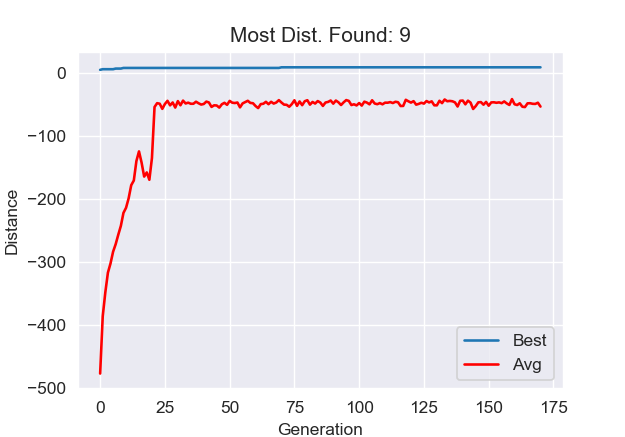

Text(0.5, 1.0, 'Most Dist. Found: 9')

In [72]:
# warning - We're using a large population here (2000) to really explore the search space
# this will take a few minutes to run.  A pop size of 200 will usually give a solution 
# with 8 districts.  Note also that there is a fixed random number seed at line 46
# so that running this code again will produce the same answer

ind_size =num_cities

# create a minimization problem
creator.create("FitnessGerry", base.Fitness, weights=(1.0, ))
# tells us what kind of individuals we'll have - arrays of integers
creator.create("Individual",list,fitness=creator.FitnessGerry)

# configure toolbox
toolbox = base.Toolbox()
# define how we create an individual and a population
def create_individual(nd,nc):
    return random.choices(range(nd),k=nc)
toolbox.register("indices",create_individual,num_districts,ind_size)
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# Fitness
toolbox.register("evaluate", fitness_districts_tuple, cities=cities)
# Selection
toolbox.register("select", tools.selTournament, tournsize=8)
# Crossover
toolbox.register("mate", tools.cxOnePoint)
# Mutation
toolbox.register("mutate", tools.mutUniformInt, low = 0, up=num_districts-1, indpb=0.15)

# configure statistics to collect
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# define search parameters
pop_size = 2000
crossover_prob = .8
mutation_prob = .25
max_gen = 500
max_no_improve = 100

# get solution - random seed added for reproducibility
random.seed(15)
best_fitness, best_assign, log = customGA(pop_size, crossover_prob, mutation_prob,
                                     max_gen, max_no_improve)

# plot search convergence
fig = plt.figure(figsize=(5, 3.5))
line_best, = plt.plot(log.select('gen'), log.select('max'), label='Best')
line_avg, = plt.plot(log.select('gen'),
                     log.select('avg'),
                     color='red',
                     label='Avg')
plt.xlabel('Generation')
plt.ylabel('Distance')
plt.legend(handles=[line_best, line_avg])
plt.title('Most Dist. Found: {:d}'.format(int(best_dist)))

In [7]:
summarize_districts(best_assign,cities)

NameError: name 'summarize_districts' is not defined

# <font color = "blue"> Self Assessment: Experiment with continuous GA </font>

In [8]:
# problem setup
def f(x):
    obj = sum(0.1 + x[i]**2 - 0.1 * np.cos(6 * np.pi * x[i])
              for i in range(len(x)))
    return obj


def f_tuple(x):
    return (
        f(x),
    )  # this version is for DEAP since it expects a tuple to be returned


low_bound = -1.0
high_bound = 1.0

ind_size = 20  # number of decision variables = dimension
  
def NonConvex2D_Explore(pop_size=20,
                        crossover_prob=.8,
                        mutation_prob=0.2,
                        max_gen=2000,
                        max_no_improve=200,
                        tournsize = 3,
                        indpb=0.1,
                        sigma=0.3):
    
    

    # define how we create an individual and a population
    def create_individual(n):
        return np.random.uniform(low_bound, high_bound, size=n).tolist()

    toolbox.register("indices", create_individual, ind_size)
    toolbox.register("individual", tools.initIterate, creator.Individual,
                     toolbox.indices)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Fitness
    toolbox.register("evaluate", f_tuple)
    # Selection
    toolbox.register("select", tools.selTournament, tournsize=tournsize)
    # Crossover
    toolbox.register("mate", tools.cxOnePoint)
    # Mutation
    toolbox.register("mutate",
                     tools.mutGaussian,
                     mu=0,
                     sigma=sigma,
                     indpb=indpb)

    # NEW - add decorator (a wrapper) to the mutation operator to clip to bounds
    def checkBounds(min, max):
        def decorator(func):
            def wrapper(*args, **kargs):
                offspring = func(*args, **kargs)
                for child in offspring:
                    for i in range(len(child)):
                        if child[i] > max:
                            child[i] = max
                        elif child[i] < min:
                            child[i] = min
                return offspring

            return wrapper

        return decorator

    toolbox.decorate("mutate", checkBounds(low_bound, high_bound))

    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # get solution
    best_val, best_x, log = customGA(pop_size, crossover_prob, mutation_prob,
                                     max_gen, max_no_improve)

    # plot search convergence
    fig = plt.figure(figsize=(5, 3.5))
    line_best, = plt.plot(log.select('gen'), log.select('min'), label='Best')
    line_avg, = plt.plot(log.select('gen'),
                         log.select('avg'),
                         color='red',
                         label='Avg')

    plt.xlabel('Generation')
    plt.ylabel('Function')
    plt.legend(handles=[line_best, line_avg])
    plt.title('Min Val Found: {:.2f}'.format(best_val))

    print(
        'The smallest value of f found is {:0.5f} at x = {:0.5f}, y = {:0.5f}'.
        format(best_val, best_x[0], best_x[1]))
    return best_val, best_x, log

<IPython.core.display.Javascript object>


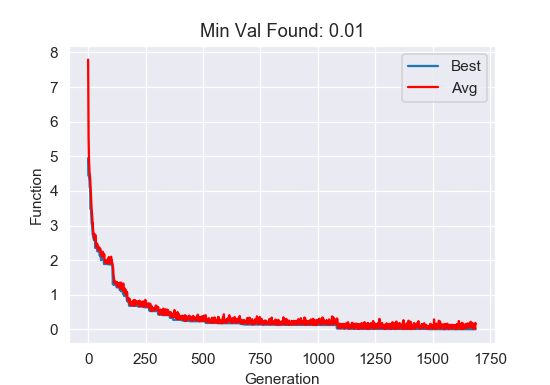

The smallest value of f found is 0.00885 at x = 0.00709, y = -0.00317


In [9]:
# copy this cell and tweak for experiments

#create a model here
creator.create("NonConvex2D", base.Fitness, weights=(-1.0, ))   
# tells us what kind of individuals we'll have - arrays of integers
creator.create("Individual", list, fitness=creator.NonConvex2D)
# configure toolbox
toolbox = base.Toolbox()
# configure statistics to collect
stats = tools.Statistics(key=lambda ind: ind.fitness.values)

val, x, log = NonConvex2D_Explore(pop_size=20,
                                  crossover_prob=0.8,
                                  mutation_prob=0.2,
                                  max_gen=2000,
                                  max_no_improve=200,
                                  tournsize = 3,
                                  indpb=0.1,
                                  sigma=0.3)

* Experiment with `tournsize`.  Tournament selection works by first choosing `tournsize` individuals from the population and then choosing the best of those to be selected.  Small values for `tournsize` allow more weaker (less optimal) individuals.  Large values make it hard for less optimal values to be selected.  How does `tournsize` affect convergence? What is happening is you make `tournsize` the same as the population size?

In [24]:
# copy this cell and tweak for experiments
#create a model here
creator.create("NonConvex2D", base.Fitness, weights=(-1.0, ))   
# tells us what kind of individuals we'll have - arrays of integers
creator.create("Individual", list, fitness=creator.NonConvex2D)
# configure toolbox
toolbox = base.Toolbox()
# configure statistics to collect
stats = tools.Statistics(key=lambda ind: ind.fitness.values)

# increasing tournsize from 3 to 10 seems to have little effect
val, x, log = NonConvex2D_Explore(pop_size=20,
                                  crossover_prob=0.8,
                                  mutation_prob=0.2,
                                  max_gen=2000,
                                  max_no_improve=200,
                                  tournsize = 10,
                                  indpb=0.1,
                                  sigma=0.3)

<IPython.core.display.Javascript object>

In [5]:
# increasing from to 20 means that all of the offspring will be the same, best individual
# the search seems to do OK though

# copy this cell and tweak for experiments
#create a model here
creator.create("NonConvex2D", base.Fitness, weights=(-1.0, ))   
# tells us what kind of individuals we'll have - arrays of integers
creator.create("Individual", list, fitness=creator.NonConvex2D)
# configure toolbox
toolbox = base.Toolbox()
# configure statistics to collect
stats = tools.Statistics(key=lambda ind: ind.fitness.values)

val, x, log = NonConvex2D_Explore(pop_size=20,
                                  crossover_prob=0.8,
                                  mutation_prob=0.2,
                                  max_gen=2000,
                                  max_no_improve=200,
                                  tournsize = 20,
                                  indpb=0.1,
                                  sigma=0.3)

NameError: name 'customGA' is not defined

* Experiment with `indpb` at line 37.  This parameter is the probability that an element of an individual will undergo a mutation.  What happens if you increase it?

In [26]:
# increasing indpb to .9 meaning that about 90% of entries in a mutated vector will change
# the search is a bit more random this way and seems to have more trouble getting very close 
# to the optimum
# copy this cell and tweak for experiments
#create a model here
creator.create("NonConvex2D", base.Fitness, weights=(-1.0, ))   
# tells us what kind of individuals we'll have - arrays of integers
creator.create("Individual", list, fitness=creator.NonConvex2D)
# configure toolbox
toolbox = base.Toolbox()
# configure statistics to collect
stats = tools.Statistics(key=lambda ind: ind.fitness.values)

val, x, log = NonConvex2D_Explore(pop_size=20,
                                  crossover_prob=0.8,
                                  mutation_prob=0.2,
                                  max_gen=2000,
                                  max_no_improve=200,
                                  tournsize = 3,
                                  indpb=0.9,
                                  sigma=0.3)

<IPython.core.display.Javascript object>

* Experiment with the scale parameter sigma.  Large values mean larger moves.  How does this parameter affect convergence?

In [27]:
# increased sigma to 1 so mutations are much more varied now.  it might have a small negative
# effect on local convergence
# copy this cell and tweak for experiments
#create a model here
creator.create("NonConvex2D", base.Fitness, weights=(-1.0, ))   
# tells us what kind of individuals we'll have - arrays of integers
creator.create("Individual", list, fitness=creator.NonConvex2D)
# configure toolbox
toolbox = base.Toolbox()
# configure statistics to collect
stats = tools.Statistics(key=lambda ind: ind.fitness.values)

val, x, log = NonConvex2D_Explore(pop_size=20,
                                  crossover_prob=0.8,
                                  mutation_prob=0.2,
                                  max_gen=2000,
                                  max_no_improve=200,
                                  tournsize = 3,
                                  indpb=0.1,
                                  sigma=1)

<IPython.core.display.Javascript object>

* What kind of search are you getting if you simply set crossover_prob = 0 and mut_prob = 1?  Is this effective?  What happens if you turn off mutation and only allow crossover?

In [28]:
# cx_prob = 0, mut_prob = 1
# this is more or less pure random search now and it doesn't converge to the global optimum
# copy this cell and tweak for experiments
#create a model here
creator.create("NonConvex2D", base.Fitness, weights=(-1.0, ))   
# tells us what kind of individuals we'll have - arrays of integers
creator.create("Individual", list, fitness=creator.NonConvex2D)
# configure toolbox
toolbox = base.Toolbox()
# configure statistics to collect
stats = tools.Statistics(key=lambda ind: ind.fitness.values)

val, x, log = NonConvex2D_Explore(pop_size=20,
                                  crossover_prob=0,
                                  mutation_prob=1,
                                  max_gen=2000,
                                  max_no_improve=200,
                                  tournsize = 3,
                                  indpb=0.1,
                                  sigma=0.3)

<IPython.core.display.Javascript object>

In [29]:
# cx_prob = 1, mut_prob = 0
# no mutations means that we're pretty much mixing the original population repeatedly 
# so it may never converge to the global optimumum unless some mix of the original population
# is (0,0,0,...,0)
# copy this cell and tweak for experiments
#create a model here
creator.create("NonConvex2D", base.Fitness, weights=(-1.0, ))   
# tells us what kind of individuals we'll have - arrays of integers
creator.create("Individual", list, fitness=creator.NonConvex2D)
# configure toolbox
toolbox = base.Toolbox()
# configure statistics to collect
stats = tools.Statistics(key=lambda ind: ind.fitness.values)

val, x, log = NonConvex2D_Explore(pop_size=20,
                                  crossover_prob=1,
                                  mutation_prob=0,
                                  max_gen=2000,
                                  max_no_improve=200,
                                  tournsize = 3,
                                  indpb=0.1,
                                  sigma=0.3)

<IPython.core.display.Javascript object>